# CAP 6615 Neural Networks Programming Assignment 2 – Multi-Layer Neural Network

### Keyuan Lu, Wenxuan Bao, Yiming Xu, Yufan Chen, Yue Bai

In [1]:
# import packages
from PIL import Image
import numpy as np
import itertools
import cv2
from matplotlib import pyplot as plt
import random 
from matplotlib.lines import Line2D
import pandas as pd
import string
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Step 1 - Design and build a dataset $𝑋$ of for character recognition of 64 16x16-pixel images (256 pixels per image) from the following online exemplars.

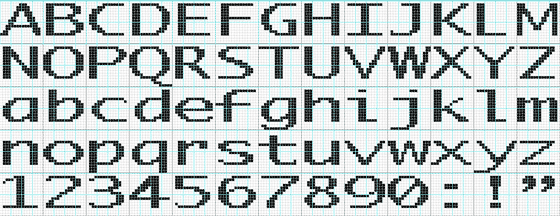

In [3]:
# you can download this 'alphabet.gif' directly from the programming assignment page on Canvas.
im = Image.open('alphabet.gif')
im

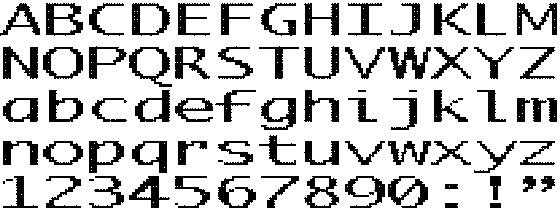

In [4]:
# convert image to black and white
im = im.convert('1')
im

In [5]:
w, h = im.size
print('width: ', w)
print('height:', h)

width:  560
height: 216


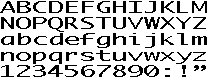

In [6]:
#resize the image
image_height = 16
image_width = 16
m = 13
n = 5
image_size = image_height*image_width
im_resize = im.resize((m*image_width, n*image_height))
im_resize

In [7]:
#check the resize image and change data type
pix = np.array(im_resize)
nrow, ncol = pix.shape
print(pix.shape)
print(pix.dtype)
# change the data type from bool to double
pix = pix.astype(np.float32)
print(pix.dtype)

(80, 208)
bool
float32


In [8]:
# construct the training dataset, validation dataset and testing dataset
n_train_sample = 32
n_val_sample = 16
n_test_sample = 32
n_channel  = 1
dataset_train = np.ndarray(shape=(n_train_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset_train.shape
dataset_train.dtype
dataset_val = np.ndarray(shape=(n_val_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset_val.shape
dataset_val.dtype
dataset_test = np.ndarray(shape=(n_test_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset_test.shape
dataset_test.dtype

dtype('float32')

In [9]:
#create dataset_all
dataset_all = np.ndarray(shape=(65, n_channel, image_height, image_width), dtype=np.float32)
dataset_all.shape
dataset_all.dtype
idx = 0
for i in range(5):
    for j in range(13):
        x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
        dataset_all[idx] = x
        idx += 1
print("All images to array!")

All images to array!


In [10]:
lowercase = list(string.ascii_lowercase)
uppercase = list(string.ascii_uppercase)
keys_full = np.array(uppercase + lowercase + list(range(1, 10)) + ['0', ':', '!', '"'])
keys_full
##A-Z is from 1 to 26
##a-z is from 27 to 52
##1 to 9 to 0 is from 53-62
## : is 63, ! is 64, " is 65  

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', ':', '!', '"'],
      dtype='<U1')

In [11]:
# flatten the data
dataset_all_reshaped = dataset_all.reshape((65, 1, -1))

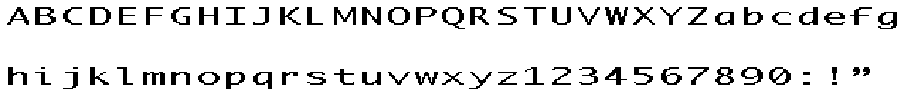

In [12]:
#print all
fig, axs = plt.subplots(2, 33 ,figsize=(16,2))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_all):
        ax.imshow(dataset_all[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

### manually select the training, validation and test dataset

In [13]:
# select training dataset based on dissimilarity
kmeans = KMeans(n_clusters=32, random_state=0).fit(dataset_all_reshaped.reshape(65,-1))
kmeans_labels = kmeans.labels_
kmeans_labels

array([31,  1,  6,  2, 20, 20,  6,  1,  9,  4,  5, 25, 19,  1,  2, 29,  2,
        5, 24,  9,  1, 11, 16, 28, 18,  8,  7,  3,  3, 15, 30, 20,  7, 26,
        0, 17, 25,  0, 21, 26, 30, 26,  7,  3, 30,  0,  7, 27, 10, 23, 13,
       23,  9,  8,  4, 14, 24,  6,  8, 12,  2,  2,  0,  9, 22])

In [14]:
labels_all = list(range(65))
keys_train = np.array([0]*n_train_sample)
labels_train = np.array([0]*n_train_sample)
for i in range(32):
    labels_train[i] = np.where(kmeans_labels == i)[0][0]
labels_train = sorted(labels_train)
labels_test = np.array(list(set(labels_all)^set(labels_train))[0:n_test_sample])
labels_test = sorted(labels_test)
keys_train =  keys_full[labels_train]
print(keys_train)
keys_test =  keys_full[labels_test]
print(keys_test)

#start from 1 to 65
labels_all = [x + 1 for x in labels_all]
labels_train = [x + 1 for x in labels_train]
labels_test = [x + 1 for x in labels_test]
# print(labels_all)
print(labels_train)
print(labels_test)              

['A' 'B' 'C' 'D' 'E' 'I' 'J' 'K' 'L' 'M' 'P' 'S' 'V' 'W' 'X' 'Y' 'Z' 'a'
 'b' 'd' 'e' 'h' 'i' 'j' 'm' 'v' 'w' 'x' 'y' '4' '8' '"']
['F' 'G' 'H' 'N' 'O' 'Q' 'R' 'T' 'U' 'c' 'f' 'g' 'k' 'l' 'n' 'o' 'p' 'q'
 'r' 's' 't' 'u' 'z' '1' '2' '3' '5' '6' '7' '9' '0' ':']
[1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 16, 19, 22, 23, 24, 25, 26, 27, 28, 30, 31, 34, 35, 36, 39, 48, 49, 50, 51, 56, 60, 65]
[6, 7, 8, 14, 15, 17, 18, 20, 21, 29, 32, 33, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 52, 53, 54, 55, 57, 58, 59, 61, 62, 63]


In [15]:
#create train
for idx in range(n_train_sample):
    dataset_train[idx] = dataset_all[labels_train[idx]-1]

#create test
for idx in range(n_test_sample):
    dataset_test[idx] = dataset_all[labels_test[idx]-1]

    
# flatten the data
dataset_train_reshaped = dataset_train.reshape((n_train_sample, 1, -1))
dataset_test_reshaped = dataset_test.reshape((n_test_sample, 1, -1))

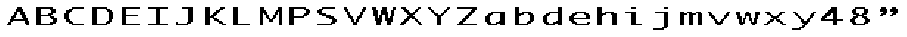

In [16]:
#print train
fig, axs = plt.subplots(1, 32 ,figsize=(16,16))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_train):
        ax.imshow(dataset_train[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

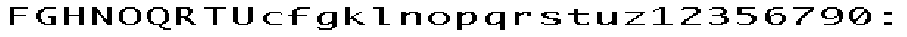

In [17]:
#print test
fig, axs = plt.subplots(1, 32 ,figsize=(16,16))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_test):
        ax.imshow(dataset_test[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [18]:
# select training dataset based on dissimilarity
kmeans = KMeans(n_clusters=16, random_state=0).fit(dataset_train_reshaped.reshape(32, -1))
kmeans_labels = kmeans.labels_
kmeans_labels

array([10,  1,  2,  1,  2,  7,  5, 12,  1,  8,  1,  5,  4, 14,  7,  0,  7,
        3,  3,  3,  3,  3,  0,  6, 13,  4,  9, 11, 15,  6,  5,  0])

In [19]:
keys_val = np.array([0]*n_val_sample)
keys_train_small = np.array([0]*n_val_sample)
labels_train_small = np.array([0]*n_val_sample)
for i in range(n_val_sample):
    labels_train_small[i] = np.where(kmeans_labels == i)[0][0]
labels_train_small = sorted(labels_train_small)
keys_train_small =  keys_train[labels_train_small]
print(keys_train_small)
labels_val = np.array(list(set(range(32))^set(labels_train_small))[0:n_val_sample])
labels_val = sorted(labels_val)
keys_val =  keys_train[labels_val]
print(keys_val)



# #start from 1 to 65
labels_train_small = np.array([np.where(keys_full == i)[0][0] for i in keys_train_small])
labels_val = np.array([np.where(keys_full == i)[0][0] for i in keys_val])
labels_train_small = [x + 1 for x in labels_train_small]
labels_val = [x + 1 for x in labels_val]
print(labels_train_small)
print(labels_val)   

['A' 'B' 'C' 'I' 'J' 'K' 'M' 'V' 'W' 'Y' 'a' 'j' 'm' 'w' 'x' 'y']
['D' 'E' 'L' 'P' 'S' 'X' 'Z' 'b' 'd' 'e' 'h' 'i' 'v' '4' '8' '"']
[1, 2, 3, 9, 10, 11, 13, 22, 23, 25, 27, 36, 39, 49, 50, 51]
[4, 5, 12, 16, 19, 24, 26, 28, 30, 31, 34, 35, 48, 56, 60, 65]


In [20]:
#create val
for idx in range(n_val_sample):
    dataset_val[idx] = dataset_all[labels_val[idx]-1]

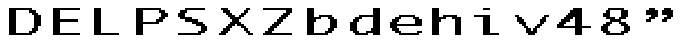

In [21]:
#print val
fig, axs = plt.subplots(1, 16 ,figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_val):
        ax.imshow(dataset_val[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()
dataset_val_reshaped = dataset_val.reshape((n_val_sample, 1, -1))

In [22]:
dataset_all_reshaped.shape

(65, 1, 256)

###  Use SIFT (Scale Invariant Feature Transformation) to derive numerical descriptive parameters from the individual data set exemplars

In [23]:
des_train = np.ndarray(shape=(n_train_sample, n_channel, image_height, image_width), dtype=np.float32)
des_train.shape
des_train.dtype
des_val = np.ndarray(shape=(n_val_sample, n_channel, image_height, image_width), dtype=np.float32)
des_val.shape
des_val.dtype
des_test = np.ndarray(shape=(n_test_sample, n_channel, image_height, image_width), dtype=np.float32)
des_test.shape
des_test.dtype

dtype('float32')

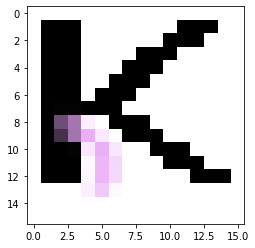

In [24]:
idx = 7
img1 = dataset_train[idx, 0]
img1 = 255 * img1 # Now scale by 255
img = img1.astype(np.uint8)
#find keypoints and descriptors
sift = cv2.xfeatures2d.SIFT_create(nfeatures=3)
kp_1, des_1 = sift.detectAndCompute(img,None)
img_1 = cv2.drawKeypoints(img, kp_1,img)
plt.imshow(img_1)

In [25]:
for idx in range(n_train_sample):
    img1 = dataset_train[idx, 0]
    img1 = 255 * img1 # Now scale by 255
    img = img1.astype(np.uint8)
    #find keypoints and descriptors
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=3)
    kp_1, des_1 = sift.detectAndCompute(img,None)
    print(des_1 is None)
#     print(des_1.shape)

    

False
False
False
False
False
True
False
False
False
True
False
False
True
False
True
True
False
True
False
False
False
False
False
False
False
False
False
True
True
False
False
False


## Step 2 - Design and develop two (MLNN) in Python, using libraries such as PyTorch (and, if necessary, Tensor Flow). 

### Approach 1-a: Simple Network with Scalar Output (use original image as input)

In [26]:
##Approach 1, Adding an extra hidden layer between input layer and output layer
class TrainableEltwiseLayer(nn.Module):
    def __init__(self,D_in):
        super(TrainableEltwiseLayer, self).__init__()
        self.weights = nn.Parameter(torch.randn(D_in))  # define the trainable parameter
        self.linear = nn.Linear(D_in,D_in)
        #self.Sigmoid = nn.Sigmoid()
        self.Relu = torch.nn.ReLU()
    def forward(self, x):
        x_1 = self.linear(x)
        #x_2 = self.Sigmoid(x_1)
        x_2 = self.Relu(x_1)
        # assuming x is of size b-1-h-w
        return torch.sum(x_2 * self.weights) + 1

### Approach 2: Fully-connected Network with Image Output:  

In [27]:
def get_Mean(model_1,model_2,model_3,model_4,model_5,x):
    out1 =model_1(x)
    out2 =model_2(x)
    out3 =model_3(x)
    out4 =model_4(x)
    out5 =model_5(x)
    my_list = [out1,out2,out3,out4,out5]
    return torch.mean(torch.stack(my_list), dim=0)


model_Ap2_1 = torch.nn.Sequential(
    nn.Linear(256, 256),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.Sigmoid()
)
model_Ap2_2 = torch.nn.Sequential(
    nn.Linear(256, 256),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.Sigmoid()
)
model_Ap2_3 = torch.nn.Sequential(
    nn.Linear(256, 256),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.Sigmoid()
)
model_Ap2_4 = torch.nn.Sequential(
    nn.Linear(256, 256),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.Sigmoid()
)
model_Ap2_5 = torch.nn.Sequential(
    nn.Linear(256, 256),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.Sigmoid()
)

### Approach 1-b: Simple Network with Scalar Output: (use SIFT metrics as input)

In [28]:
def random_bagging(indices, All_label_ensemble, All_train_ensemble):
    label_out = []
    train_out = []
    for x in indices:
        label_out.append(All_label_ensemble[x])
        train_out.append(All_train_ensemble[x])
    
    return np.array(train_out),np.array(label_out)
    
    
    return  np.delete(All_train_ensemble,indices,0),np.delete(All_label_ensemble,indices,0)
def majority_vote(model_1,model_2,model_3,model_4,model_5,x):
    out1 =round(model_1(x).float().item())
    out2 =round(model_2(x).float().item())
    out3 =round(model_3(x).float().item())
    out4 =round(model_4(x).float().item())
    out5 =round(model_5(x).float().item())
    list = [out1,out2,out3,out4,out5]
    return max(set(list),key=list.count)
                
    
    
###Create ensemble 10 bagging, with training size 32
model_Ap1_1 = TrainableEltwiseLayer(256)
model_Ap1_2 = TrainableEltwiseLayer(256)
model_Ap1_3 = TrainableEltwiseLayer(256)
model_Ap1_4 = TrainableEltwiseLayer(256)
model_Ap1_5 = TrainableEltwiseLayer(256)

list_1 = random.choices(range(0,32),k=32)
list_2 = random.choices(range(0,32),k=32)
list_3 = random.choices(range(0,32),k=32)
list_4 = random.choices(range(0,32),k=32)
list_5 = random.choices(range(0,32),k=32)

ensemble1_train,ensemble1_label= random_bagging(list_1, labels_train, dataset_train_reshaped)
ensemble2_train,ensemble2_label= random_bagging(list_2, labels_train, dataset_train_reshaped)
ensemble3_train,ensemble3_label= random_bagging(list_3, labels_train, dataset_train_reshaped)
ensemble4_train,ensemble4_label= random_bagging(list_4, labels_train, dataset_train_reshaped)
ensemble5_train,ensemble5_label= random_bagging(list_5, labels_train, dataset_train_reshaped)

## Step 3 - Train your MLNNs on your Training Set (from Step 1, above) then test each MLNN to ensure it functions correctly before you go on to Step 4.

In [29]:
def train_ModelAp1(model_ensemble, train_data, train_label, bagsize):
    #set seed for reproducible results 
    torch.manual_seed(1)
    np.random.seed(1)
    # define loss function.
    loss_fn = nn.MSELoss()
    # Use the optim package to define an Optimizer that will update the weights of the model for us. 
    learning_rate = 1e-5
    optimizer = optim.Adam(model_ensemble.parameters(), lr=learning_rate)
    loss_all_1 = []
    for t in range (1000):
        for i, data in enumerate(train_data):
            y = torch.from_numpy(np.array(train_label[i])).float()
            x = torch.from_numpy(data).float()
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = model_ensemble(x)

            # Compute and print loss.
            loss = loss_fn(y_pred, y)
            #if (i % bagsize == 25 ) and (t % 10 == 0 ):
            #   print("Epoch {} - loss: {}".format(t, loss.item()))
            if (i % bagsize == bagsize-1 ):
                loss_all_1 += [loss]

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()
    return loss_all_1,model_ensemble

In [30]:
loss_all_ensemble_Ap1_1,model_Ap1_1 = train_ModelAp1(model_Ap1_1,ensemble1_train,ensemble1_label,32)
loss_all_ensemble_Ap1_2,model_Ap1_2 = train_ModelAp1(model_Ap1_2,ensemble2_train,ensemble2_label,32)
loss_all_ensemble_Ap1_3,model_Ap1_3 = train_ModelAp1(model_Ap1_3,ensemble3_train,ensemble3_label,32)
loss_all_ensemble_Ap1_4,model_Ap1_4 = train_ModelAp1(model_Ap1_4,ensemble4_train,ensemble4_label,32)
loss_all_ensemble_Ap1_5,model_Ap1_5 = train_ModelAp1(model_Ap1_5,ensemble5_train,ensemble5_label,32)

Text(0, 0.5, 'MSEloss')

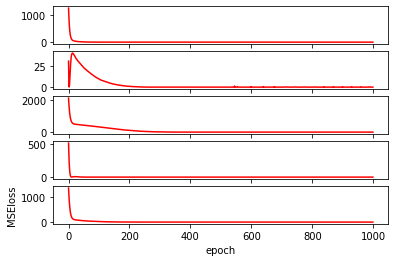

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(5,1,1)
ax1.plot(np.array(loss_all_ensemble_Ap1_1), 'r')
ax2 = fig.add_subplot(5,1,2)
ax2.plot(np.array(loss_all_ensemble_Ap1_2), 'r')
ax3 = fig.add_subplot(5,1,3)
ax3.plot(np.array(loss_all_ensemble_Ap1_3), 'r')
ax4 = fig.add_subplot(5,1,4)
ax4.plot(np.array(loss_all_ensemble_Ap1_4), 'r')
ax5 = fig.add_subplot(5,1,5)
ax5.plot(np.array(loss_all_ensemble_Ap1_5), 'r')
plt.xlabel("epoch")
plt.ylabel("MSEloss")


In [32]:
# training result in approach 1
cor = 0
for i, data in enumerate(dataset_train_reshaped):
    x = torch.from_numpy(data)
    label = labels_train[i]
    out = majority_vote(model_Ap1_1,model_Ap1_2,model_Ap1_3,model_Ap1_4,model_Ap1_5,x)
    if out < 1:
        out = 1
    if out > 65:
        out = 65
    if out == label:
        cor += 1 
    print("answer: {},output {}".format(label, out))
print("accuracy:{}".format(cor/n_train_sample))

answer: 1,output 1
answer: 2,output 2
answer: 3,output 32
answer: 4,output 4
answer: 5,output 5
answer: 9,output 9
answer: 10,output 10
answer: 11,output 11
answer: 12,output 12
answer: 13,output 13
answer: 16,output 16
answer: 19,output 19
answer: 22,output 22
answer: 23,output 23
answer: 24,output 24
answer: 25,output 25
answer: 26,output 26
answer: 27,output 49
answer: 28,output 28
answer: 30,output 30
answer: 31,output 31
answer: 34,output 34
answer: 35,output 35
answer: 36,output 36
answer: 39,output 39
answer: 48,output 48
answer: 49,output 49
answer: 50,output 50
answer: 51,output 51
answer: 56,output 56
answer: 60,output 60
answer: 65,output 65
accuracy:0.9375


In [33]:

def train_ModelAp2(model_ensemble, train_data, bagsize, showProgress):
    #set seed for reproducible results 
    torch.manual_seed(1)
    np.random.seed(1)
    # define loss function.
    loss_fn = nn.MSELoss()
    # Use the optim package to define an Optimizer that will update the weights of the model for us. 
    learning_rate = 1e-3
    optimizer = optim.Adam(model_ensemble.parameters(), lr=learning_rate)
    loss_all_2 = []
    for t in range (300):
        for i, data in enumerate(train_data):
            y = torch.from_numpy(data)
            x = torch.from_numpy(data)
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = model_ensemble(x)

            # Compute and print loss.
            loss = loss_fn(y_pred, y)      
            # if (i % bagsize == bagsize-1 ) and (t % 10 == 0 ):
            #    print("Epoch {} - loss: {}".format(t, loss.item()))

            if (i % bagsize  == 0 ):
                loss_all_2 += [loss]

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()
            if(showProgress):
                if (i % bagsize == bagsize-1 ) and (t in [ 0, 4, 9, 49, 99 ,199] ):
                    fig, axs = plt.subplots(1, bagsize ,figsize=(16, 16))
                    for j, data_j in enumerate(train_data):
                        x = torch.from_numpy(data_j)
                        output = model_ensemble(x)
                        output[output > 0.5] = 1
                        output[output <= 0.5] = 0
                        pred = output.detach().numpy()
                        pred = pred.reshape((image_height, image_width ))
                        ax = axs.flatten()[j]
                        ax.imshow(pred, cmap='gray', interpolation='nearest')
                        ax.axis('off')
    return loss_all_2,model_ensemble

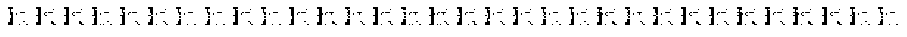

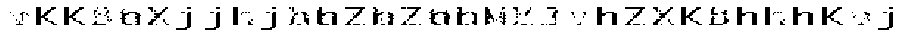

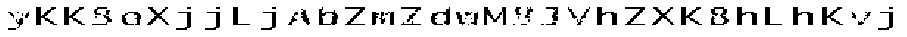

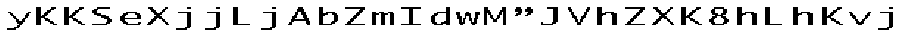

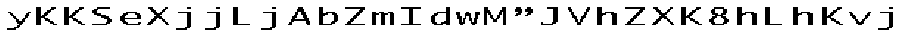

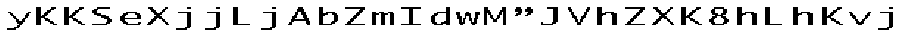

In [34]:
loss_all_ensemble_Ap2_1,model_Ap2_1 = train_ModelAp2(model_Ap2_1,ensemble1_train,32,True)
loss_all_ensemble_Ap2_2,model_Ap2_2 = train_ModelAp2(model_Ap2_2,ensemble2_train,32,False)
loss_all_ensemble_Ap2_3,model_Ap2_3 = train_ModelAp2(model_Ap2_3,ensemble3_train,32,False)
loss_all_ensemble_Ap2_4,model_Ap2_4 = train_ModelAp2(model_Ap2_4,ensemble4_train,32,False)
loss_all_ensemble_Ap2_5,model_Ap2_5 = train_ModelAp2(model_Ap2_5,ensemble5_train,32,False)

Text(0, 0.5, 'MSEloss')

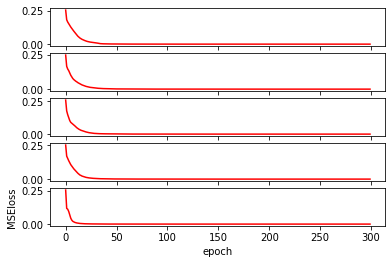

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(5,1,1)
ax1.plot(np.array(loss_all_ensemble_Ap2_1), 'r')
ax2 = fig.add_subplot(5,1,2)
ax2.plot(np.array(loss_all_ensemble_Ap2_2), 'r')
ax3 = fig.add_subplot(5,1,3)
ax3.plot(np.array(loss_all_ensemble_Ap2_3), 'r')
ax4 = fig.add_subplot(5,1,4)
ax4.plot(np.array(loss_all_ensemble_Ap2_4), 'r')
ax5 = fig.add_subplot(5,1,5)
ax5.plot(np.array(loss_all_ensemble_Ap2_5), 'r')
plt.xlabel("epoch")
plt.ylabel("MSEloss")

### Here, we consider using the validation set to eliminate the overfitting issue for the model 2

## Step 4 - Test your MLNN on the Test Set developed in 1), above -- with no noise introduced into the input dataset. 

answer: 6,output 33
answer: 7,output 36
answer: 8,output 33
answer: 14,output 33
answer: 15,output 32
answer: 17,output 15
answer: 18,output 20
answer: 20,output 15
answer: 21,output 32
answer: 29,output 38
answer: 32,output 26
answer: 33,output 43
answer: 37,output 21
answer: 38,output 27
answer: 40,output 41
answer: 41,output 41
answer: 42,output 40
answer: 43,output 47
answer: 44,output 34
answer: 45,output 33
answer: 46,output 40
answer: 47,output 33
answer: 52,output 34
answer: 53,output 15
answer: 54,output 24
answer: 55,output 32
answer: 57,output 32
answer: 58,output 35
answer: 59,output 32
answer: 61,output 34
answer: 62,output 35
answer: 63,output 35
accuracy:0.03125


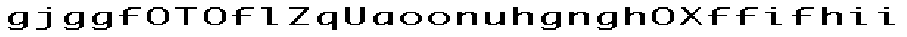

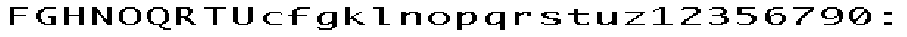

In [36]:
# test approach 1
cor = 0
fig, axs = plt.subplots(1, n_test_sample, figsize=(16,16))
for i, data in enumerate(dataset_test_reshaped):
    x = torch.from_numpy(data)
    label = labels_test[i]
    out = majority_vote(model_Ap1_1,model_Ap1_2,model_Ap1_3,model_Ap1_4,model_Ap1_5,x)
    if out < 1:
        out = 1
    if out > 65:
        out = 65
    if out == label:
        cor += 1 
    pred = dataset_all[out-1, 0]
    ax = axs.flatten()[i]
    ax.imshow(pred, cmap='gray', interpolation='nearest')
    ax.axis('off')
    print("answer: {},output {}".format(label, out))
print("accuracy:{}".format(cor/n_test_sample))


#print test
fig, axs = plt.subplots(1, n_test_sample, figsize=(16,16))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_test):
        ax.imshow(dataset_test[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [37]:
#Compute metrics 
def metrics(target, pred):
    Fh = sum((target == 0) & (target == pred))/ sum(target == 0)
    Ffa = sum((target == 1) & (target != pred))/ sum(target == 1)
    return Fh, Ffa

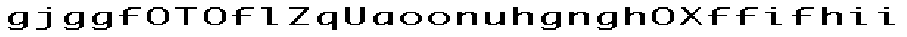

In [38]:
# model 1
Fh_res = []
Ffa_res = []
fig, axs = plt.subplots(1, n_test_sample ,figsize=(16, 16))
for i, data in enumerate(dataset_test_reshaped):
    x = torch.from_numpy(data)
    label = labels_test[i]
    out = majority_vote(model_Ap1_1,model_Ap1_2,model_Ap1_3,model_Ap1_4,model_Ap1_5,x)
    if out < 1:
        out = 1
    if out > 65:
        out = 65
    pred = dataset_all[out-1, 0]
    ax = axs.flatten()[i]
    ax.imshow(pred, cmap='gray', interpolation='nearest')
    ax.axis('off')
    x = x.flatten().detach().numpy()
    y = pred.flatten()
    Fh, Ffa = metrics(x, y)
    Fh_res+= [Fh]
    Ffa_res+= [Ffa]

Text(0, 0.5, 'Fh')

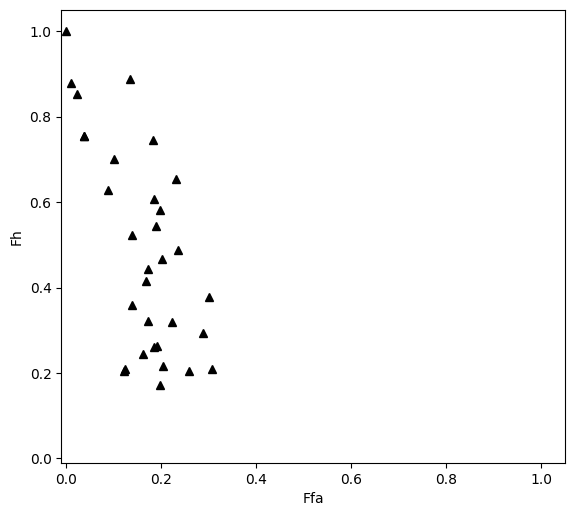

In [39]:
plt.figure(figsize=[6.5,6],dpi=100)
plt.plot(Ffa_res, Fh_res, '^', color='black');
plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)
plt.xlabel("Ffa")
plt.ylabel("Fh")

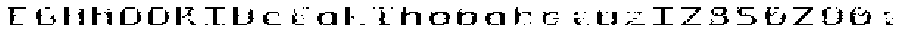

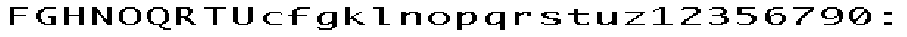

In [40]:
#model 2
Fh_res = []
Ffa_res = []
fig, axs = plt.subplots(1, n_test_sample ,figsize=(16, 16))

for i, data in enumerate(dataset_test_reshaped):
    x = torch.from_numpy(data)
    output = get_Mean(model_Ap2_1,model_Ap2_2,model_Ap2_3,model_Ap2_4,model_Ap2_5,x)
    output[output > 0.5] = 1
    output[output <= 0.5] = 0
    pred = output.detach().numpy()
    pred = pred.reshape((image_height, image_width ))
    ax = axs.flatten()[i]
    ax.imshow(pred, cmap='gray', interpolation='nearest')
    ax.axis('off')
    x = x.flatten().detach().numpy()
    y = output.flatten().detach().numpy()
    Fh, Ffa = metrics(x, y)
    Fh_res+= [Fh]
    Ffa_res+= [Ffa]
    
#print test
fig, axs = plt.subplots(1, n_test_sample, figsize=(16,16))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_test):
        ax.imshow(dataset_test[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

Text(0, 0.5, 'Fh')

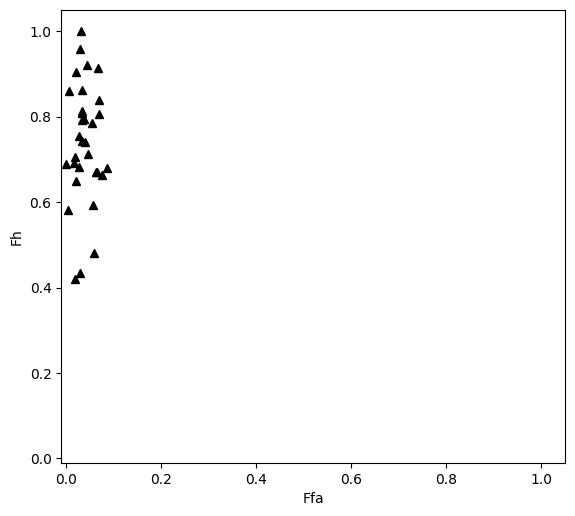

In [41]:
plt.figure(figsize=[6.5,6],dpi=100)
plt.plot(Ffa_res, Fh_res, '^', color='black');
plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)
plt.xlabel("Ffa")
plt.ylabel("Fh")
# plt.savefig('Fh_Ffa_noiseless.eps')

## Step 5 - Compute Receiver Operating Characteristic (ROC) from the results of Step 4 (for each MLNN) and graph the result,

In [42]:
# model 1
y_test = np.empty(0, int)
y_score = np.empty(0)
for i, data in enumerate(dataset_test_reshaped):
    x = torch.from_numpy(data)
    label = labels_test[i]
    out = majority_vote(model_Ap1_1,model_Ap1_2,model_Ap1_3,model_Ap1_4,model_Ap1_5,x)
    if out < 1:
        out = 1
    if out > 65:
        out = 65
    pred = dataset_all[out-1, 0]
    x = x.flatten().detach().numpy()
    y = pred.flatten() 
    y_test = np.append(y_test, x)
    y_score = np.append(y_score, y)

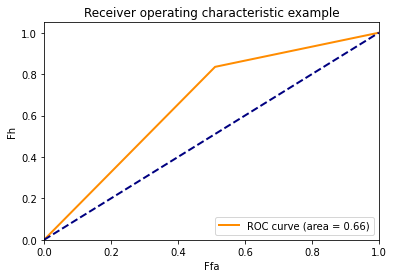

In [43]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [44]:
#model 2
y_test = np.empty(0, int)
y_score = np.empty(0)
for i, data in enumerate(dataset_test_reshaped):
    x = torch.from_numpy(data)
    output = get_Mean(model_Ap2_1,model_Ap2_2,model_Ap2_3,model_Ap2_4,model_Ap2_5,x)
    y = output.flatten().detach().numpy()
    y_score = np.append(y_score, y)
    #output[output > 0.5] = 1
    #output[output <= 0.5] = 0
    x = x.flatten().detach().numpy()   
    y_test = np.append(y_test, x)


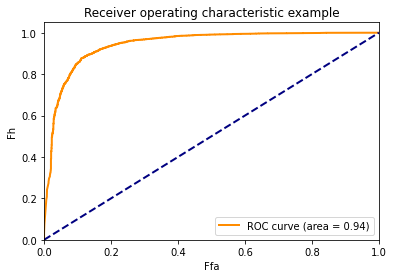

In [45]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


## Step 6 - 6a) Corrupt your Test Set (from 1), above) by adding noise; 

In [46]:
# standard deviation
sd = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 25)
        index = random.sample(list(range(256)), 25)
        dataset_noise[i] = dataset[i]    
        dataset_noise[i, 0, index] = dataset_noise[i, 0, index] + s
        dataset_noise[i,0] = NormalizeData(dataset_noise[i,0 ])
    return dataset_noise   

### 6b) Repeat Tests in Step 4), above, with noise-corrupted Test Set and gather the results into a table of Fh and Ffa versus test-image-ID, with one row for each value of the standard deviation

#### model 1

In [47]:
#model 1
Fh_res_all = []
Ffa_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(dataset_test_reshaped, sigma)
    # test results
    Fh_res = []
    Ffa_res = []
    fig, axs = plt.subplots(1, n_test_sample ,figsize=(12, 12))
    for i, data in enumerate(dataset_test_noise):
        x = torch.from_numpy(data)
        label = labels_test[i]
        out = majority_vote(model_Ap1_1,model_Ap1_2,model_Ap1_3,model_Ap1_4,model_Ap1_5,x)
        if out < 1:
            out = 1
        if out > 65:
            out = 65
        pred = dataset_all[out-1, 0]
        ax = axs.flatten()[i]
        ax.imshow(pred, cmap='gray', interpolation='nearest')
        ax.axis('off')
        x = dataset_test_reshaped[i].reshape([-1])
        y = pred.flatten()
        Fh, Ffa = metrics(x, y)
        Fh_res+= [Fh]
        Ffa_res+= [Ffa]
    Fh_res_all.append(Fh_res)
    Ffa_res_all.append(Ffa_res)

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [48]:
Fh_res_all[7]

[0.7169811320754716,
 0.59375,
 0.5189873417721519,
 0.15217391304347827,
 0.21621621621621623,
 0.8780487804878049,
 0.6153846153846154,
 0.2916666666666667,
 0.726027397260274,
 0.20512820512820512,
 0.41509433962264153,
 0.1111111111111111,
 0.6065573770491803,
 0.4318181818181818,
 0.6612903225806451,
 0.6964285714285714,
 0.7534246575342466,
 0.1506849315068493,
 0.6744186046511628,
 0.3076923076923077,
 0.56,
 0.25806451612903225,
 0.32558139534883723,
 0.5098039215686274,
 0.4444444444444444,
 0.49122807017543857,
 0.3559322033898305,
 0.5138888888888888,
 0.5217391304347826,
 0.4383561643835616,
 0.5903614457831325,
 0.6]

Text(0.5, 1.0, 'Graph of Fh and Ffa vs. Noise Standard Deviation\n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Heteroassociative  Multi-Layer Neural Network')

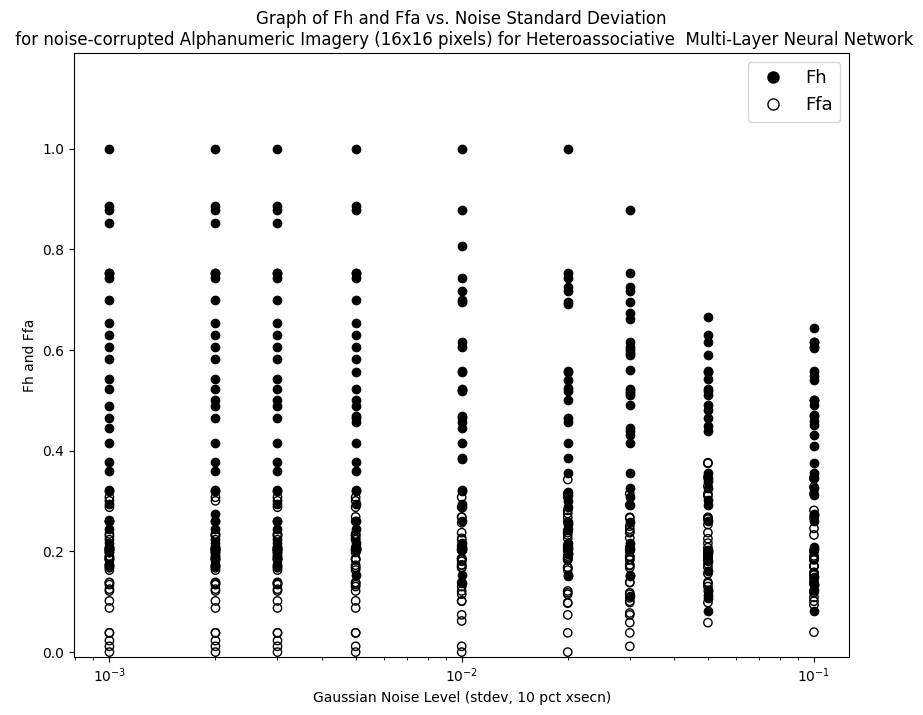

In [49]:
plt.figure(figsize=[10,8],dpi=100)
for i in range(1, len(sd)):
    plt.plot([sd[i]]*n_test_sample, Fh_res_all[i],'o', color='black')
    plt.scatter([sd[i]]*n_test_sample, Ffa_res_all[i], facecolors='none', edgecolors='black')
    plt.xscale('log')

# plt.xlim(0, 0.1)
plt.ylim(-0.01, 1.19)
plt.xlabel("Gaussian Noise Level (stdev, 10 pct xsecn)")
plt.ylabel("Fh and Ffa")
legend_elements = [Line2D([0], [0], marker='o', color='k', lw=0, markersize=8, markerfacecolor='k', label='Fh'),
                  Line2D([0], [0], marker='o', color='k', lw=0, markersize=8, markerfacecolor='w', label='Ffa')]
plt.legend(handles=legend_elements,fontsize=13)
# plt.text(0.002,1.1,'Training set = { \'C\', \'D\', \'E\', \'H\', \'I\', \'1\', \'3\', \'4\', \'5\', \'9\'}',fontsize=13)
plt.title("Graph of Fh and Ffa vs. Noise Standard Deviation\n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Heteroassociative  Multi-Layer Neural Network")

# plt.savefig('Fh_Ffa_noise.eps')

In [50]:
##A-Z is from 1 to 26
##a-z is from 27 to 52
##1 to 9 to 0 is from 53-62
## : is 63, ! is 64, " is 65  
labels = keys_full[[x - 1 for x in labels_test]]
Fh_df=pd.DataFrame(Fh_res_all,columns=labels,index=sd).T
Ffa_df=pd.DataFrame(Ffa_res_all,columns=labels,index=sd).T

In [51]:
table=pd.DataFrame()
for i in range(Fh_df.shape[1]):
    table=pd.concat([table,Fh_df.iloc[:,i],Ffa_df.iloc[:,i]],axis=1)
table=table.round(decimals=2)
table

,0.000,0.000,0.001,0.001,0.002,0.002,0.003,0.003,0.005,0.005,0.010,0.010,0.020,0.020,0.030,0.030,0.050,0.050,0.100,0.100
F,0.38,0.30,0.38,0.30,0.38,0.30,0.38,0.30,0.38,0.30,0.72,0.07,0.72,0.07,0.72,0.07,0.30,0.33,0.47,0.09
G,0.17,0.20,0.17,0.20,0.17,0.20,0.17,0.20,0.20,0.13,0.20,0.13,0.31,0.19,0.59,0.17,0.20,0.13,0.31,0.33
H,0.58,0.20,0.58,0.20,0.58,0.20,0.58,0.20,0.58,0.20,0.52,0.24,0.52,0.24,0.52,0.24,0.52,0.24,0.47,0.04
N,0.54,0.19,0.54,0.19,0.54,0.19,0.54,0.19,0.15,0.21,0.15,0.21,0.15,0.21,0.15,0.21,0.54,0.19,0.27,0.17
O,0.22,0.20,0.22,0.20,0.22,0.20,0.22,0.20,0.22,0.20,0.22,0.20,0.22,0.20,0.22,0.20,0.11,0.23,0.14,0.19
Q,0.88,0.01,0.88,0.01,0.88,0.01,0.88,0.01,0.88,0.01,0.88,0.01,0.52,0.24,0.88,0.01,0.12,0.20,0.13,0.16
R,0.24,0.16,0.24,0.16,0.24,0.16,0.24,0.16,0.24,0.16,0.62,0.10,0.24,0.16,0.62,0.10,0.45,0.26,0.62,0.10
T,0.21,0.31,0.21,0.31,0.21,0.31,0.21,0.31,0.21,0.31,0.21,0.31,0.21,0.31,0.29,0.25,0.29,0.38,0.21,0.35
U,0.26,0.19,0.26,0.19,0.26,0.19,0.26,0.19,0.26,0.19,0.26,0.19,0.73,0.10,0.73,0.10,0.26,0.19,0.64,0.19
c,0.36,0.14,0.36,0.14,0.36,0.14,0.36,0.14,0.36,0.14,0.38,0.21,0.38,0.21,0.21,0.19,0.67,0.25,0.41,0.17


#### model 2

In [52]:
#model 2
Fh_res_all = []
Ffa_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(dataset_test_reshaped, sigma)
    # test results
    Fh_res = []
    Ffa_res = []
    fig, axs = plt.subplots(1, n_test_sample ,figsize=(12, 12))
    for i, data in enumerate(dataset_test_noise):
        x = torch.from_numpy(data)
        output = get_Mean(model_Ap2_1,model_Ap2_2,model_Ap2_3,model_Ap2_4,model_Ap2_5,x)
        output[output > 0.5] = 1
        output[output <= 0.5] = 0
        pred = output.detach().numpy()
        pred = pred.reshape((image_height, image_width ))
        ax = axs.flatten()[i]
        ax.imshow(pred, cmap='gray', interpolation='nearest')
        ax.axis('off')
        x = dataset_test_reshaped[i].reshape([-1])
        y = output.flatten().detach().numpy()
        Fh, Ffa = metrics(x, y)
        Fh_res+= [Fh]
        Ffa_res+= [Ffa]
    Fh_res_all.append(Fh_res)
    Ffa_res_all.append(Ffa_res)

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


Text(0.5, 1.0, 'Graph of Fh and Ffa vs. Noise Standard Deviation\n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Autoassociative Multi-Layer Neural Network')

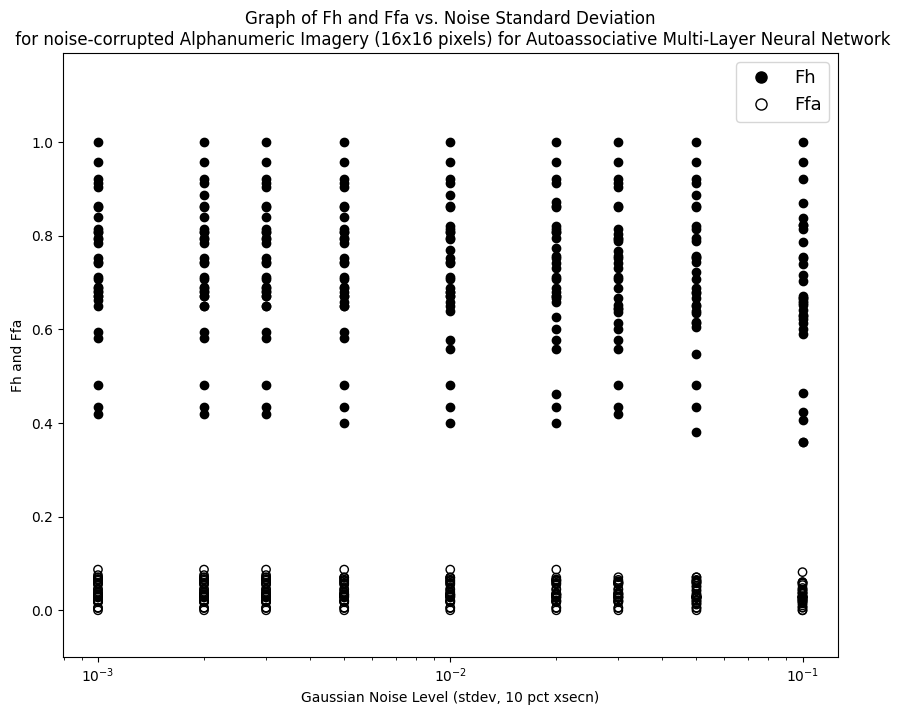

In [53]:
plt.figure(figsize=[10,8],dpi=100)
for i in range(1, len(sd)):
    plt.plot([sd[i]]*n_test_sample, Fh_res_all[i],'o', color='black')
    plt.scatter([sd[i]]*n_test_sample, Ffa_res_all[i], facecolors='none', edgecolors='black')
    plt.xscale('log')

# plt.xlim(0, 0.1)
plt.ylim(-0.1, 1.19)
plt.xlabel("Gaussian Noise Level (stdev, 10 pct xsecn)")
plt.ylabel("Fh and Ffa")
legend_elements = [Line2D([0], [0], marker='o', color='k', lw=0, markersize=8, markerfacecolor='k', label='Fh'),
                  Line2D([0], [0], marker='o', color='k', lw=0, markersize=8, markerfacecolor='w', label='Ffa')]
plt.legend(handles=legend_elements,fontsize=13)
# plt.text(0.002,1.1,'Training set = { \'C\', \'D\', \'E\', \'H\', \'I\', \'1\', \'3\', \'4\', \'5\', \'9\'}',fontsize=13)
plt.title("Graph of Fh and Ffa vs. Noise Standard Deviation\n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Autoassociative Multi-Layer Neural Network")

# plt.savefig('Fh_Ffa_noise.eps')

In [54]:
##A-Z is from 1 to 26
##a-z is from 27 to 52
##1 to 9 to 0 is from 53-62
## : is 63, ! is 64, " is 65  
labels = keys_full[[x - 1 for x in labels_test]]
Fh_df=pd.DataFrame(Fh_res_all,columns=labels,index=sd).T
Ffa_df=pd.DataFrame(Ffa_res_all,columns=labels,index=sd).T

In [55]:
table=pd.DataFrame()
for i in range(Fh_df.shape[1]):
    table=pd.concat([table,Fh_df.iloc[:,i],Ffa_df.iloc[:,i]],axis=1)
table=table.round(decimals=2)
table


,0.000,0.000,0.001,0.001,0.002,0.002,0.003,0.003,0.005,0.005,0.010,0.010,0.020,0.020,0.030,0.030,0.050,0.050,0.100,0.100
F,0.79,0.03,0.79,0.03,0.79,0.03,0.79,0.03,0.79,0.03,0.79,0.03,0.77,0.03,0.79,0.03,0.75,0.03,0.62,0.03
G,0.59,0.06,0.59,0.06,0.59,0.06,0.59,0.06,0.59,0.06,0.58,0.06,0.58,0.06,0.58,0.06,0.55,0.05,0.41,0.04
H,0.86,0.01,0.86,0.01,0.86,0.01,0.86,0.01,0.86,0.01,0.86,0.01,0.86,0.01,0.86,0.01,0.86,0.01,0.82,0.01
N,0.71,0.02,0.71,0.02,0.71,0.02,0.71,0.02,0.71,0.02,0.71,0.02,0.71,0.02,0.71,0.02,0.71,0.01,0.65,0.01
O,0.78,0.05,0.78,0.05,0.78,0.05,0.78,0.05,0.78,0.05,0.77,0.05,0.76,0.05,0.76,0.05,0.76,0.05,0.72,0.04
Q,0.67,0.06,0.67,0.06,0.67,0.06,0.67,0.06,0.67,0.06,0.67,0.06,0.67,0.06,0.65,0.06,0.63,0.06,0.67,0.06
R,0.74,0.03,0.74,0.03,0.74,0.03,0.74,0.03,0.74,0.03,0.74,0.03,0.73,0.03,0.73,0.03,0.68,0.03,0.63,0.03
T,0.96,0.03,0.96,0.03,0.96,0.03,0.96,0.03,0.96,0.03,0.96,0.03,0.96,0.03,0.96,0.03,0.96,0.03,0.96,0.03
U,0.86,0.03,0.86,0.03,0.86,0.03,0.86,0.03,0.86,0.03,0.86,0.03,0.86,0.03,0.86,0.03,0.86,0.03,0.82,0.03
c,0.79,0.04,0.79,0.04,0.79,0.04,0.79,0.04,0.79,0.04,0.79,0.04,0.79,0.04,0.79,0.04,0.74,0.03,0.67,0.02


### 6c)  Calculate your ROC Curves

In [56]:
cmaps= ['purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue', 'red']

In [57]:
#model 1
y_test_all =[]
y_score_all =[]
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(dataset_test_reshaped, sigma)
    # test results
    y_test = np.empty(0, int)
    y_score = np.empty(0)
    for i, data in enumerate(dataset_test_noise):
        x = torch.from_numpy(data)
        out =majority_vote(model_Ap1_1,model_Ap1_2,model_Ap1_3,model_Ap1_4,model_Ap1_5,x)
        if out < 1:
            out = 1
        if out > 65:
            out = 65
        pred = dataset_all[out-1, 0]      
        x = dataset_test_reshaped[i].reshape([-1])
        y = pred.flatten()
        y_score = np.append(y_score, y)
        y_test = np.append(y_test, x)
    y_test_all.append(y_test)
    y_score_all.append(y_score)

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


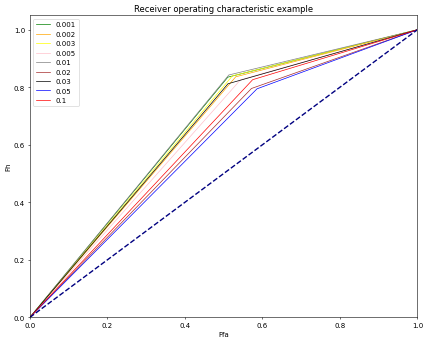

In [58]:
plt.figure(figsize=[10,8],dpi=50)
for i in range(1, len(sd)):
    fpr, tpr, _ = roc_curve(y_test_all[i], y_score_all[i])
    roc_auc = auc(fpr, tpr)
#     print(fpr)
    plt.plot(fpr, tpr, color=cmaps[i], lw=1, label = sd[i])   
    lw = 2
#     
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
plt.legend()
plt.show()


In [59]:
#model 2
y_test_all =[]
y_score_all =[]
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(dataset_test_reshaped, sigma)
    # test results
    y_test = np.empty(0, int)
    y_score = np.empty(0)
    for i, data in enumerate(dataset_test_noise):
        x = torch.from_numpy(data)
        output =  get_Mean(model_Ap2_1,model_Ap2_2,model_Ap2_3,model_Ap2_4,model_Ap2_5,x)
        x = dataset_test_reshaped[i].reshape([-1])
        y = output.flatten().detach().numpy()
        y_score = np.append(y_score, y)
        y_test = np.append(y_test, x)
    y_test_all.append(y_test)
    y_score_all.append(y_score)

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


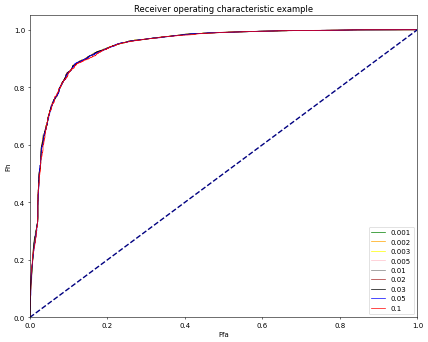

In [60]:
plt.figure(figsize=[10,8],dpi=50)
for i in range(1, len(sd)):
    fpr, tpr, _ = roc_curve(y_test_all[i], y_score_all[i])
    roc_auc = auc(fpr, tpr)
#     print(fpr)
    plt.plot(fpr, tpr, color=cmaps[i], lw=1, label = sd[i])   
    lw = 2
#     
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
plt.legend()
plt.show()
